In [56]:
import numpy as np
from numpy import sin,cos,exp,tan,log,log10

import scipy as s
from scipy.integrate import odeint
from scipy import pi

import matplotlib.pyplot as plt
import time


# NOTE: magnetic moment is fixed in direction //z





seed = 6  # parameter to create file name (it starts with this integer number)

# choice of word "seed" is derived from other programmes I have written
# where "seed" was actually a random number to distinguish otherwise same filenames
# "code" would perhaps be more appropriate here
#
# relevant values of "seed":
# 1 - initial few investigations
# 2 - began experimenting with reducing g
# 3 - simulations taken the week before end of summer presentation (mid-september 2020)

In [57]:
# physical parameters

reduce_g = 0.2 # reduce g in order to see radial oscillations in a shorter tube with shorter time !!!
g = reduce_g * 9.81   # gravity acceleration (N/kg)

a = 0.05   # radius of tube (m)
H = 0.5  # length of tube (m)
h = 0.01   # thickness of tube (m)
sigma = 5.92e7   # conductivity of tube material (Siemens)
mu = 4*pi*1e-7   # magnetic permeability
m = 2   # dipole moment (A/m^2)
M = 0.0030   # mass of magnet (kg)



# simulation parameters
t_max = 2
max_iter = 2000   # total number of iterations in time
dt = t_max/max_iter

init_height = 0.0*H # setting the initial condition z[0]
init_displ = 0.0*a  # setting the initial condition x[0]

N = 100  # number of ring partitions of tube
dH = H/N   # height of one ring
R = 2*pi*a/(sigma*h*dH)   # resistance of one ring (Ohm)
allIndices = np.arange(N)
Z_ring = -(allIndices+1/2) * dH   # array that stores effective positions of rings (midpoints in z)

#print(Z_ring)




# in this section, create list of mutual inductances of all possible pairs (z-displacements) of rings in tube
# NB: need to be careful, as displacements below are always positive (integer (>0) multiples of dH)
z_example = -0.5*dH  # example ring coordinate to produce array: DZ = z_example - Z_ring = [0,1*dH,2*dH,...,(N-1)*dH]


# now we compute array whose indices encode inductances of rings "index" apart from each other
# this has advantage that we do not need to calculate it every iteration - we just look it up in this array!
list_mutual_inductances = np.zeros(N)
for n in range(N):
    mut_ind_integrand = lambda ro,phi: ro * (a - ro*cos(phi)) / (ro**2 + a**1 + (z_example-Z_ring[n])**2 - 2*a*ro*cos(phi))**(3/2)
    list_mutual_inductances[n] = -mu/2 * s.integrate.dblquad(mut_ind_integrand, 0, 2*pi, lambda phi: 0, lambda phi: a)[0] 
print(list_mutual_inductances)

J = np.zeros((max_iter,N)) # just a reminder, defined in next cell!

def mut_ind(n,p):
    """This function calculates the mutual inductance of two rings with indices n and (dummy) p
    by looking them up in list_mutual_inductances array, attention on signs: M12 = M21"""
    return list_mutual_inductances[np.abs(n-p)]
mut_ind = np.vectorize(mut_ind) # vectorize this function to enable its treatment as in emf_tube

def der_t_current(J,i,p):
    """This function calculates the time derivative of current in ring n at time t_i from matrix J 
    by using suitable algorhitm, its output is needed in function emf_tube, below"""
    #print(type(J))
    #print(type(J[i,p]))
    return (J[i,p]-J[i-1,p]) / dt  
der_t_current = np.vectorize(der_t_current)

def emf_tube(J_after,J_before,i,n):
    """This function calculates the e.m.f. from variations of induced currents in all the other rings in the tube,
    for a ring with index n at time i"""
    #return np.sum( mut_ind(n, allIndices) * der_t_current(J, i, allIndices) )  # sum through dummy index p, i.e. allIndices: from p = 0 (trough p = n) to N-1
    emf = 0
    for p in range(N):
        emf += mut_ind(n,p) * (J_after[p]-J_before[p]) / dt
    return emf
#emf_tube = np.vectorize(emf_tube)
    
def emf_mag(x,z,vz):
    """This function calculates the e.m.f. by doing integral "v cross B" along the body of the ring, neglecting the vx component
    of motion, which is much smaller than vz component."""
    v = z/a
    u = x/a
    integral =  s.integrate.quad(lambda phi: v * (1 - u*cos(phi)) / (1 + u**2 - 2*u*cos(phi) + v**2)**(5/2), 0, 2*pi )
    integral = integral[0]
    integral *= - 3 * mu/4/pi * m * vz / a**2
    return integral

emf_mag = np.vectorize(emf_mag)
print()
print(emf_mag(0.1*a,np.array([a,2*a,3*a]),-1))


def force_z(x,z,current):
    """Magnetic force of an elemental ring in z-direction, argument z interpreted as z(magnet) - z_ring"""
    u = x/a
    v = z/a
    integral = s.integrate.quad(lambda phi: v * (1 - u*cos(phi)) / (1 + u**2 + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral = integral[0]
    integral *= + 3 * mu/4/pi * m / a**2 * current
    return integral
    
def force_x(x,z,current):
    """Magnetic force of an elemental ring in x-direction, argument z interpreted as z(magnet) - z_ring"""
    u = x/a
    v = z/a
    integral = s.integrate.quad(lambda phi: cos(phi) * (1 + u**2  - 2*v**2 - 2*u*cos(phi)) / (1 + u**2  + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral = integral[0]
    integral *= +  mu/4/pi * m / a**2 * current
    return integral




[ -2.05993916e-08  -2.05846026e-08  -2.05403417e-08  -2.04669260e-08
  -2.03648778e-08  -2.02349164e-08  -2.00779458e-08  -1.98950411e-08
  -1.96874306e-08  -1.94564781e-08  -1.92036622e-08  -1.89305554e-08
  -1.86388030e-08  -1.83301019e-08  -1.80061795e-08  -1.76687744e-08
  -1.73196180e-08  -1.69604168e-08  -1.65928382e-08  -1.62184963e-08
  -1.58389411e-08  -1.54556484e-08  -1.50700129e-08  -1.46833418e-08
  -1.42968514e-08  -1.39116644e-08  -1.35288087e-08  -1.31492184e-08
  -1.27737343e-08  -1.24031071e-08  -1.20380000e-08  -1.16789929e-08
  -1.13265861e-08  -1.09812052e-08  -1.06432061e-08  -1.03128795e-08
  -9.99045638e-09  -9.67611257e-09  -9.36997381e-09  -9.07212044e-09
  -8.78259194e-09  -8.50139121e-09  -8.22848870e-09  -7.96382624e-09
  -7.70732058e-09  -7.45886675e-09  -7.21834107e-09  -6.98560400e-09
  -6.76050266e-09  -6.54287318e-09  -6.33254277e-09  -6.12933161e-09
  -5.93305457e-09  -5.74352266e-09  -5.56054440e-09  -5.38392699e-09
  -5.21347731e-09  -5.04900285e-09

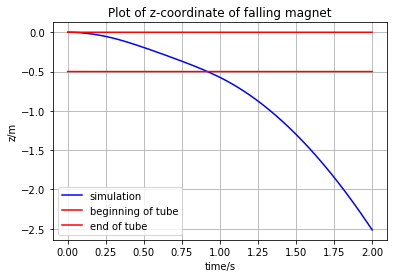

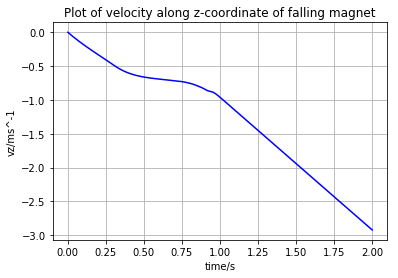

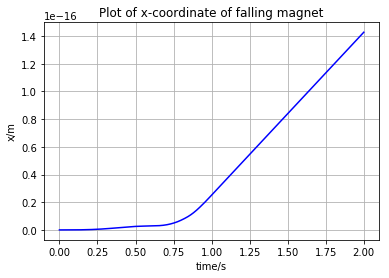

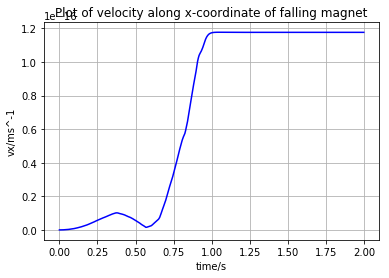

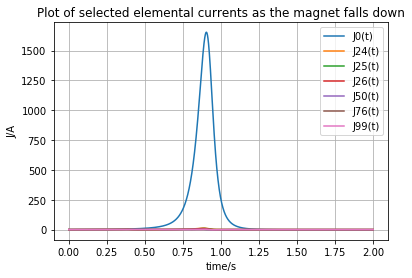

final coordinate of magnet, in cm: -251.51
and in case of free fall, in cm:   -392.40


simulation took 1022.47 s


In [58]:
# initiate arrays that store our data

T = np.linspace(0,t_max,max_iter)   # array that stores all points in time 

z = np.zeros((max_iter))   # array that stores coordinates of magnet along axes as time progresses
vz = np.zeros((max_iter))
az = np.zeros((max_iter))

x = np.zeros((max_iter))   # array that stores radial coordinates of magnet in x-z plane as time progresses
vx = np.zeros((max_iter))
ax = np.zeros((max_iter))

J = np.zeros((max_iter, N))  # array that stores currents (in Amperes) in all rings as time progresses
Fx = np.zeros((max_iter, N)) # array that stores lateral forces (in Newtons) in all rings as time progresses
Fz = np.zeros((max_iter, N)) # array that stores vertical forces (in Newtons) in all rings as time progresses



# now implement ICs to get values for first two iterations

z[0] = init_height
az[0] = -g
vz[0] = 1/2*dt*az[0] # vz[0] is in fact vz[1/2], all indices for velocity are shifted forwards by 1/2
z[1] = z[0] + vz[0]*dt

x[0] = init_displ
ax[0] = 0
vx[0] = 1/2*dt*ax[0] # vx[0] is in fact vx[1/2], all indices for velocity are shifted forwards by 1/2
x[1] = x[0] + vx[0]*dt

J[0,:] = 0
# in calculation of J[1,:] use extrapolated velocity between V[1/2] and V[3/2] to approximate V[1]
J[1,:] = 1/R  *  ( emf_mag(x[1],z[1]-Z_ring,vz[0]+1/2*dt*az[0]))
#print(J[1,:])
#print(type(J[1,:]))
#print(type(J[1,1]))
#for n in range(N):
    #print( emf_tube(J,1,n))
    #print(type(emf_tube(J,1,n)))
    #J[1,n] += 1/R * emf_tube(J,1,n)
#print(J[1,:])




# solve using a finite difference approach "x[t+dt] = x[t] + dt*x'[t+1/2*dt]"

sim_start = time.time()

for i in range(1,max_iter-1):
        
    for n in range(N):  # quite stupid way, should later vectorize, but probably would not make much difference,
                        # as looping is likely negligible compared to all these horrible numerical integrations
        Fx[i,n] = force_x(x[i], z[i]-Z_ring[n], J[i,n])
        Fz[i,n] = force_z(x[i], z[i]-Z_ring[n], J[i,n])
        
    ax[i] = 1/M * sum(Fx[i,:])   # sum all forces corresponding to separate rings at iteration i
    az[i] = -g + 1/M * sum(Fz[i,:])
    
    vx[i] = vx[i-1] + ax[i]*dt   # e.g. for i=1: V[3/2] = V[1/2] + A[1]*dt
    vz[i] = vz[i-1] + az[i]*dt   # e.g. for i=1: V[3/2] = V[1/2] + A[1]*dt
    
    x[i+1] = x[i] + vx[i]*dt   # e.g. for i=1: Z[2] = Z[1] + V[3/2]*dt
    z[i+1] = z[i] + vz[i]*dt   # e.g. for i=1: Z[2] = Z[1] + V[3/2]*dt
    
    for n in range(N):
        J[i+1,n] = 1/R * emf_mag(x[i+1], z[i+1]-Z_ring[n],vz[i]+1/2*dt*az[i]) # e.g. for i=1: J[2] = f( Z[2], V[3/2]+A[2]*1/2*dt )
        # note: this implementation ASSUMES that emf_tube << emf_mag and treats it only as a correction!
        # this is due to difficulties in getting the time derivative of current - we need it to compute J[i,n]
        # but it requires J[i+1,n] and/or J[i,n] which are still unknown! - and we cannot bring it easily on LHS of equation
        # ratio emf_mag/emf_tube should be checked during simulation for consistency of this assumption!!!
        J[i+1,n] += 1/R * emf_tube(J[i+1,:], J[i,:],i+1,n)

sim_end = time.time()    
    
    
    
plt.plot(T,z,'b',label='simulation')
#plt.plot(T,init_height-1/2*g*T**2,'g',label='free fall')
plt.plot(T, 0*np.ones(max_iter),'r', label='beginning of tube')
plt.plot(T, -H*np.ones(max_iter),'r', label='end of tube')
plt.legend()
plt.xlabel('time/s')
plt.ylabel('z/m')
plt.title('Plot of z-coordinate of falling magnet')
plt.grid()
plt.show()

plt.plot(T[:-1],vz[:-1],'b')
plt.xlabel('time/s')
plt.ylabel('vz/ms^-1')
plt.title('Plot of velocity along z-coordinate of falling magnet')
plt.grid()
plt.show()

plt.plot(T,x,'b',label='simulation')
plt.xlabel('time/s')
plt.ylabel('x/m')
plt.title('Plot of x-coordinate of falling magnet')
plt.grid()
plt.show()

plt.plot(T[:-1],vx[:-1],'b')
plt.xlabel('time/s')
plt.ylabel('vx/ms^-1')
plt.title('Plot of velocity along x-coordinate of falling magnet')
plt.grid()
plt.show()

for k in [0, N//4-1, N//4, N//4+1, N//2, 3*N//4+1, N-1]:
    plt.plot(T, J[:,k], label='J'+str(k)+'(t)')
plt.xlabel('time/s')
plt.ylabel('J/A')
plt.legend()
plt.title('Plot of selected elemental currents as the magnet falls down')
plt.grid()
plt.show()
    



folder = 'python_arrays'
np.savetxt('{}/{}_x_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), x)
np.savetxt('{}/{}_vx_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), vx)
np.savetxt('{}/{}_z_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), z)
np.savetxt('{}/{}_vz_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), vz)
np.savetxt('{}/{}_J_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), J)


#ref = -65.1665
print("final coordinate of magnet, in cm:","{:.2f}".format(z[-1]*100))
#print("value from ref. simulation, in cm:", ref)
print("and in case of free fall, in cm:  ","{:.2f}".format((init_height-1/2*g*T[-1]**2)*100))
print()
#print("percentage error of reduction in free-fall distance from reference:  ",(z[-1]*100-ref)/((init_height-1/2*g*T[-1]**2)*100 - ref) * 100,"%")
print()
print("simulation took","{:.2f}".format(sim_end-sim_start),"s")


In [ ]:
# investigate the spatial dependence of forces

gridlength = 200
X = np.linspace(0, 3*a, gridlength)
Z = np.linspace(0,3*a,gridlength)
x_fix = 0.2*a  # when investigating quantity(z) at x=const.
z_fix = 1*a    # when investigating quantity(x) at z=const.
#J = 1  # fix current to be 1 Ampere
Fx_x, Fx_z, Fz_x, Fz_z = np.zeros(gridlength), np.zeros(gridlength), np.zeros(gridlength), np.zeros(gridlength)

for i in range(gridlength):
    Fx_x[i] = force_x(X[i], z_fix, 1)
    Fx_z[i] = force_x(x_fix, Z[i], 1)
    Fz_x[i] = force_z(X[i], z_fix, 1)
    Fz_z[i] = force_z(x_fix, Z[i], 1)

plt.plot(X/a, Fx_x, label="Fx(x)")
plt.plot(X/a, Fz_x, label="Fz(x)")
plt.plot(X/a, 0*X,'k')
plt.legend()
plt.grid()
plt.title("Radial and axial forces as functions of radial coordinate x, at z = a")
plt.xlabel('x/a')
plt.ylabel('F/N')
#plt.show()

plt.plot(Z/a, Fx_z, label="Fx(z)")
plt.plot(Z/a, Fz_z, label="Fz(z)")
plt.plot(Z/a, 0*Z, 'k')
plt.legend()
plt.grid()
plt.title("Radial and axial forces as functions of axial coordinate z , at x = 0.2 a")
plt.xlabel('z/a')
plt.ylabel('F/N')
#plt.show()


# investigate the spatial dependence of d_phi_mag / d_z , which corresponds to e.m.f. for vz = 1 m/s

gridlength = 400
X = np.linspace(-2*a, 2*a, gridlength)
Z = np.linspace(-2*a,2*a,gridlength)
x_fix, z_fix = 0.2*a , 1*a
emf_x, emf_z = np.zeros(gridlength), np.zeros(gridlength)
#J = 1

for i in range(gridlength):
    
    emf_x[i] = emf_mag(X[i], z_fix, 1)
    emf_z[i] = emf_mag(x_fix, Z[i], 1)

plt.plot(X/a, emf_x, label="emf(x)")
plt.plot(X/a, 0*X,'k')
#plt.legend()
plt.grid()
plt.title("e.m.f. as function of radial coordinate x, at z = " + str("{:.1f}".format(z_fix/a)) + "a, and unit J, vz")
plt.xlabel('x/a')
plt.ylabel('emf/V')
#plt.show()

plt.plot(Z/a, emf_z, label="emf(z)")
plt.plot(Z/a, 0*Z,'k')
#plt.legend()
plt.grid()
plt.title("e.m.f. as function of axial coordinate z, at x = " + str("{:.1f}".format(x_fix/a)) + "a, and unit J, vz")
plt.xlabel('z/a')
plt.ylabel('emf/V')
#plt.show()


In [ ]:
# values for self inductances by formula from Maxwell


[  2.15214569e-07   1.72199378e-07   1.30420435e-07   1.07441326e-07
   9.24204435e-08   8.18888682e-08   7.42569712e-08   6.86469074e-08
   6.45141398e-08   6.14933725e-08   5.93257871e-08   5.78207717e-08
   5.68340305e-08   5.62541757e-08   5.59940301e-08   5.59847044e-08
   5.61714012e-08   5.65103404e-08   5.69664487e-08   5.75115874e-08
   5.81231717e-08   5.87830825e-08   5.94768020e-08   6.01927220e-08
   6.09215883e-08   6.16560529e-08   6.23903115e-08   6.31198108e-08
   6.38410103e-08   6.45511893e-08   6.52482900e-08   6.59307896e-08
   6.65975970e-08   6.72479675e-08   6.78814346e-08   6.84977532e-08
   6.90968547e-08   6.96788093e-08   7.02437958e-08   7.07920772e-08
   7.13239806e-08   7.18398808e-08   7.23401875e-08   7.28253346e-08
   7.32957715e-08   7.37519567e-08   7.41943516e-08   7.46234170e-08
   7.50396093e-08   7.54433777e-08   7.58351626e-08   7.62153938e-08
   7.65844894e-08   7.69428551e-08   7.72908837e-08   7.76289546e-08
   7.79574341e-08   7.82766747e-08   7.85870161e-08   7.88887848e-08
   7.91822943e-08   7.94678460e-08   7.97457288e-08   8.00162202e-08
   8.02795862e-08   8.05360817e-08   8.07859514e-08   8.10294297e-08
   8.12667411e-08   8.14981011e-08   8.17237160e-08   8.19437838e-08
   8.21584940e-08   8.23680285e-08   8.25725617e-08   8.27722607e-08
   8.29672860e-08   8.31577913e-08   8.33439244e-08   8.35258268e-08
   8.37036345e-08   8.38774782e-08   8.40474831e-08   8.42137698e-08
   8.43764539e-08   8.45356466e-08   8.46914548e-08   8.48439814e-08
   8.49933251e-08   8.51395810e-08   8.52828406e-08   8.54231921e-08
   8.55607202e-08   8.56955065e-08   8.58276297e-08   8.59571656e-08
   8.60841873e-08   8.62087650e-08   8.63309668e-08   8.64508580e-08]

[  2.65720849e-04   5.36006492e-05   1.42469065e-05

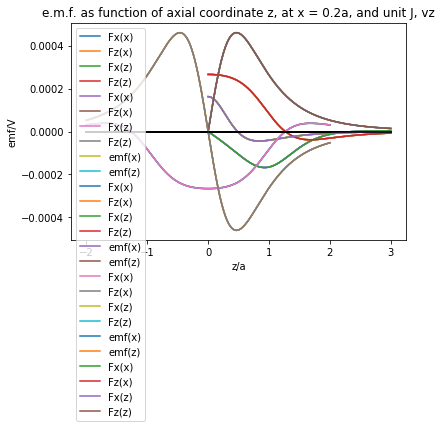

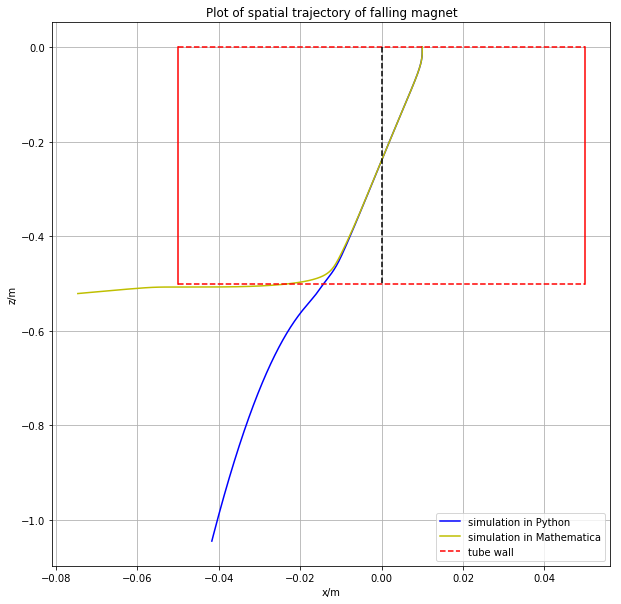

In [15]:
# this cell loads data for a Mathematica and a Python simulation 
# in order to plot trajectories of magnet in both simulations
# one should check that physical and simulation parameters agree!!!

# modify simulation parameters in filename, the file containing array
# with corresponding simulation is then loaded (if exists!)
X_py = np.genfromtxt("python_arrays/3_x_N100_iter3000_t3")
Z_py = np.genfromtxt("python_arrays/3_z_N100_iter3000_t3")

# likewise for Mathematica files
X_wm = np.genfromtxt("mathematica_arrays/sim1_U.dat")
Z_wm = np.genfromtxt("mathematica_arrays/sim1_Z.dat")

plt.figure(figsize=(10,10))
plt.plot(X_py, Z_py, 'b', label='simulation in Python')
plt.plot(X_wm, Z_wm, 'y', label='simulation in Mathematica')
plt.plot([-a,+a], [-H,-H],'r--', label='tube wall')
plt.plot([-a,+a], [0,0],'r--')
plt.plot([-a,-a], [0, -H], 'r')
plt.plot([+a,+a], [0, -H], 'r')
plt.plot([0,0], [0, -H], 'k--')
plt.xlabel('x/m')
plt.ylabel('z/m')
plt.legend()
plt.title('Plot of spatial trajectory of falling magnet')
plt.grid()
plt.show()

In [13]:
# discarded code

"""
# examination of motion as it changes with different number N of partitions of tube 

T = np.linspace(0,t_max,max_iter)   # array that stores all points in time 

x_N100 = np.loadtxt('python_arrays/1_x_N100_iter1500_t10')
x_N300 = np.loadtxt('python_arrays/1_x_N300_iter1500_t10')
x_N1000 = np.loadtxt('python_arrays/1_x_N1000_iter1500_t10')

plt.plot(T,x_N100, 'p', label='N = 100')
plt.plot(T,x_N300, 'b', label='N = 300')
plt.plot(T,x_N1000, 'g', label='N = 1000')
plt.legend()
plt.title('Comparision of x-motion for various number of ring partitions while keeping other parameters fixed')
plt.xlabel('time/s')
plt.ylabel('x/m')
plt.show()
"""

"\n# examination of motion as it changes with different number N of partitions of tube \n\nT = np.linspace(0,t_max,max_iter)   # array that stores all points in time \n\nx_N100 = np.loadtxt('python_arrays/1_x_N100_iter1500_t10')\nx_N300 = np.loadtxt('python_arrays/1_x_N300_iter1500_t10')\nx_N1000 = np.loadtxt('python_arrays/1_x_N1000_iter1500_t10')\n\nplt.plot(T,x_N100, 'p', label='N = 100')\nplt.plot(T,x_N300, 'b', label='N = 300')\nplt.plot(T,x_N1000, 'g', label='N = 1000')\nplt.legend()\nplt.title('Comparision of x-motion for various number of ring partitions while keeping other parameters fixed')\nplt.xlabel('time/s')\nplt.ylabel('x/m')\nplt.show()\n"

In [ ]:
"""

Notes on graphs:

e.g. N = 50
- this is manifested in number of "ripples" in vz graph, as the magnitude of force slightly varies as magnet falls w.r.t. centres of rings (current density as function of z is a delta comb with N spikes)
- these ripples are modulated by a wave with twice the frequency of radial oscillations - as for the evaluation of z-forces, it is the same whether the magnet is on +ve side with +/- velocity or on -ve side with -/+ velocity
- why is there such a huge noise in vx? i.e. what is the source of small ripples in x data?

- these concepts best seen in file "tube_off_axis-Copy6.ipynb"

"""

In [22]:
E = np.array([1,2,3])
def raise_matrix(E,n):
    #return E**n
    for k,e in enumerate(E):
        E[k] = E[k]**n
    return E
raise_matrix(E,2)

array([1, 4, 9])